In [106]:
from qutip import (sigmax, sigmay, tensor, basis, Qobj)
from qutip.metrics import fidelity
from qutip_qip.circuit import QubitCircuit
from qutip_qip.compiler import GateCompiler, Instruction
from qutip_qip.device import ModelProcessor
from qutip.qip.noise import ControlAmpNoise
from qutip.qip.operations.gates import *

import numpy as np
import functools # for reduce
from scipy.signal import argrelextrema 
# Import function to generate a gate set and add inverse gates 
from inverse_search import gates_set_generator, matrix_list, add_inverse_gates
from NTU_sim import NTU_processor, NTU_simulation, NTU_compiler

In [107]:
import matplotlib.pyplot as plt
from qutip.solver import Options
options = Options(nsteps =10000)
from NTU_noise import FPGA_noise

In [108]:
import sys
import os

path = os.path.abspath('D:\Code\ph7013_project_TanYuanzhengPaul\qutip\qutip-qip\src\qutip_qip\circuit\_decompose.py')
sys.path.append(path)

<>:4: DeprecationWarning: invalid escape sequence '\C'
<>:4: DeprecationWarning: invalid escape sequence '\C'
C:\Users\XPS13-9360\AppData\Local\Temp\ipykernel_16160\3364514933.py:4: DeprecationWarning: invalid escape sequence '\C'
  path = os.path.abspath('D:\Code\ph7013_project_TanYuanzhengPaul\qutip\qutip-qip\src\qutip_qip\circuit\_decompose.py')


In [109]:
class NTU_compiler(GateCompiler):
    """
    Custom compiler for generating pulses from gates using
    the base class GateCompiler.

    Args:
        num_qubits (int): The number of qubits in the processor
        params (dict): A dictionary of parameters for gate pulses
                       such as the pulse amplitude.
    """

    def __init__(self, num_qubits, params):
        super().__init__(num_qubits, params=params)
        self.params = params
        self.gate_compiler = {
            "RX": self.pulse_discretization_compiler,
            "RY": self.pulse_discretization_compiler,
        }

    def generate_pulse(self, gate, tlist, coeff, phase=0.0):
        """Generates the pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.
            tlist (array): A list of times for the evolution.
            coeff (array): An array of coefficients for the gate pulses
            phase (float): The value of the phase for the gate.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        pulse_info = [
            # (control label, coeff)
            ("sx" + str(gate.targets[0]), phase[0] * coeff),
            ("sy" + str(gate.targets[0]), phase[1] * coeff),
        ]
        return [Instruction(gate, tlist=tlist, pulse_info=pulse_info)]

    def pulse_discretization_compiler(self, gate, args):
        """Compiles single-qubit gates to pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        # gate.arg_value is the rotation angle
        if gate.name == "RX":
            phiNaught = 0
        elif gate.name == "RY":
            phiNaught = np.pi/2
        
        VNaught = self.params["VNaught"]
        VStd = self.params["VStd"]
        phaseStd = self.params["phaseStd"]
        omega = self.params["omega"]
        aNaught = self.params["aNaught"]
        detuningStd = self.params["detuningStd"]

        V = VNaught + np.random.normal(scale=VStd)
        phi = phiNaught + np.random.normal(scale=phaseStd)
        I = np.cos(phi)
        Q = np.sin(phi)

        _step_list = np.linspace(0,1,21) # a time step list so that the noise work
        coupling_time_series = np.abs(gate.arg_value) / (V*omega*np.pi) * _step_list
        s = aNaught - (1 - aNaught) * np.cos(2 * np.pi * _step_list[:-1])
        #FPGA_voltage = V * omega * np.sign(gate.arg_value) * s
        FPGA_voltage = np.sign(gate.arg_value) * V * omega  * np.pi * np.ones(20)
        #dwt = np.random.normal(scale=0.1) * coupling_time_series[:-1]
        dwt = np.random.normal(scale=detuningStd) * coupling_time_series[:-1]
        phase = [- I * np.cos(dwt) + Q * np.sin(dwt),
                 I * np.sin (dwt) - Q *np.cos(dwt)]
        if gate.name == "RX":
            return self.generate_pulse(gate, tlist = coupling_time_series, coeff = FPGA_voltage, phase=phase)
        elif gate.name == "RY":
            return self.generate_pulse(gate, tlist = coupling_time_series, coeff = FPGA_voltage, phase=phase)


In [110]:
class NTU_simulation:
    def __init__(self, processor, compiler,
                 num_qubits: int, param_dict: dict,
                 init_state = None, t1 = None, t2 = None, add_FPGA_noise = True,
                 ):
        self.processor = processor
        self.compiler = compiler
        self.num_qubits = num_qubits
        self.param_dict = param_dict
        self.init_state = init_state
        self.t1 = t1
        self.t2 = t2
        self.add_FPGA_noise = add_FPGA_noise
        self.gates_set = self.find_gates_set()

    def find_gates_set(self, plot_fidelity = False):
        fidelity_list = []
        index_list = []
        
        for x in np.linspace(0.01,6,100):
            myprocessor = self.processor(self.num_qubits)
            myprocessor.native_gates = None  # Remove the native gates
            mycompiler = self.compiler(self.num_qubits, self.param_dict)

            # Ground state for n qubits
            init_state = functools.reduce(lambda a, b: tensor(a,b), [basis(2, 0)] * self.num_qubits)

            # Define a random circuit.
            circuit = QubitCircuit(self.num_qubits)
            circuit.add_gate("RY", targets=0, arg_value=x*np.pi)

            # Simulate the circuit.
            myprocessor.load_circuit(circuit, compiler=mycompiler)
            
            # Compute results of the run using a solver of choice
            result = myprocessor.run_state(init_state, solver="mesolve",options = options)
            # Measured fidelity at the end
            fidelity_list.append(fidelity(result.states[0],result.states[-1]))
            index_list.append(x)
            
        maximum_array = argrelextrema(np.asarray(fidelity_list), np.greater,order = 10)
        first_max = maximum_array[0][0]
        pulse_coeff = index_list[first_max]/2
        
        if plot_fidelity == True:
            plt.plot(index_list,fidelity_list)

        if np.round(pulse_coeff,2) == 1:
            print('Gate set unchanged')
            return gates_set_generator(1)
        else:
            print(f'Gate set changed, pulse_coeff = {pulse_coeff}')
            return gates_set_generator(pulse_coeff)
        
    def single_sim_processor(self, num_gates:int):
        # The actual simulation
        myprocessor = self.processor(self.num_qubits, t1 = self.t1, t2 = self.t2)
        myprocessor.native_gates = None  # Remove the native gates
        mycompiler = self.compiler(self.num_qubits, self.param_dict)

        # Ground state for n qubits
        if self.init_state is None:
            self.init_state = functools.reduce(lambda a, b: tensor(a,b), [basis(2, 0)] * self.num_qubits)

        # Define a random circuit.
        circuit = QubitCircuit(self.num_qubits)
        clifford = rx(0)
        for ind in np.random.randint(0, 6, num_gates):
            circuit.add_gate(self.gates_set[ind])
            clifford = matrix_list[ind] * clifford

        # Finding inverse Clifford for the random sequence of gate
        add_inverse_gates(clifford, self.init_state, circuit = circuit, gates_set = self.gates_set)

        # Simulate the circuit.
        myprocessor.load_circuit(circuit, compiler=mycompiler)
        
        # FPGA gaussian noise
        if self.add_FPGA_noise == True:
            FPGA_noise_sim = FPGA_noise(amplitude = self.param_dict['FPGA_noise_strength'], indices=[0,1],
                                    dt=1e-2/(self.param_dict['VNaught']*self.param_dict['omega']*np.pi),
                                    rand_gen=np.random.normal, loc=0.00, 
                                    scale = 0.3)
            myprocessor.add_noise(FPGA_noise_sim)

        return myprocessor

    def single_sim(self, num_gates: int, plot_pulse = False):
        myprocessor = self.single_sim_processor(num_gates)
        
        if plot_pulse == True:
            # Plot the ideal pulse
            fig1, axis1 = myprocessor.plot_pulses(
                title="Original control amplitude", figsize=(5,3),show_axis=True,rescale_pulse_coeffs=False,
                use_control_latex=False)

            # Plot the noisy pulse
            qobjevo, _ = myprocessor.get_qobjevo(noisy=True)
            noisy_coeff_x = qobjevo.to_list()[1][1] + qobjevo.to_list()[2][1]
            noisy_coeff_y = qobjevo.to_list()[3][1] + qobjevo.to_list()[4][1]
            fig2, axis2 = myprocessor.plot_pulses(
                title="Noisy control amplitude", figsize=(5,3),show_axis=True, rescale_pulse_coeffs=False,
                use_control_latex=False)
            axis2[0].step(qobjevo.tlist, noisy_coeff_x)
            axis2[1].step(qobjevo.tlist, noisy_coeff_y)

        # Compute results of the run using a solver of choice
        result = myprocessor.run_state(self.init_state, solver="mesolve",options = options)
        # Measured fidelity at the end
        final_fidelity = fidelity(result.states[0],result.states[-1])
        return final_fidelity
            
    def test_run(self, num_samples: int, num_gates_list: list):        
        fidelity_average = []
        fidelity_error = []
        for num_gates in num_gates_list:
            fidelity_list = [self.single_sim(int(num_gates)) for i in range(num_samples)]
            fidelity_average.append(np.mean(fidelity_list))
            fidelity_error.append(np.std(fidelity_list) / np.sqrt(num_samples))
        
        return fidelity_average, fidelity_error

In [111]:
x = 10

In [112]:
VStd = 0.1
phaseStd = 0.382 / 180 * np.pi

detuningStd = 52769 /x
samplingRate = 5898.24e6/x # 5.89824 GS/s
omega = 20e6/x # 20MHz

VNaught = 1
hbar = 1
phiNaught = 0
aNaught = 25 / 46

V = VNaught + np.random.normal(scale=VStd)
phi = phiNaught + np.random.normal(scale=phaseStd)
I = np.cos(phi)
Q = np.sin(phi)

# Decoherence time
T1 = 8.66e-6/ (2*np.pi) * x
T1_err = 0.49
T2 = 9.08e-6/ (2*np.pi) * x
T2_err = 0.74e-6
T2_echo = 16.14e-6
T2_echo_err = 3.21e-6

In [113]:
4.7789115646258497e-08

4.7789115646258497e-08

In [114]:
param_dict ={"VNaught": VNaught, "VStd": VStd, "phaseStd":phaseStd,
            "omega": omega, "aNaught": aNaught, "detuningStd": detuningStd,
            "FPGA_noise_strength": VNaught * omega}

In [115]:
num_qubits = 1
num_gates_list = np.arange(5,105,20)
num_samples = 5

In [116]:
baseline = NTU_simulation(NTU_processor, NTU_compiler, 1, param_dict, add_FPGA_noise = False, t1 = None, t2 = None)
t1t2 = NTU_simulation(NTU_processor, NTU_compiler, 1, param_dict, add_FPGA_noise = False, t1 = T1, t2 = T2)
FPGA = NTU_simulation(NTU_processor, NTU_compiler, 1, param_dict, add_FPGA_noise = True, t1 = None, t2 = None)
FPGA_t1t2 = NTU_simulation(NTU_processor, NTU_compiler, 1, param_dict, add_FPGA_noise = True, t1 = T1, t2 = T2)

Gate set unchanged
Gate set unchanged
Gate set unchanged
Gate set unchanged


Gate set unchanged


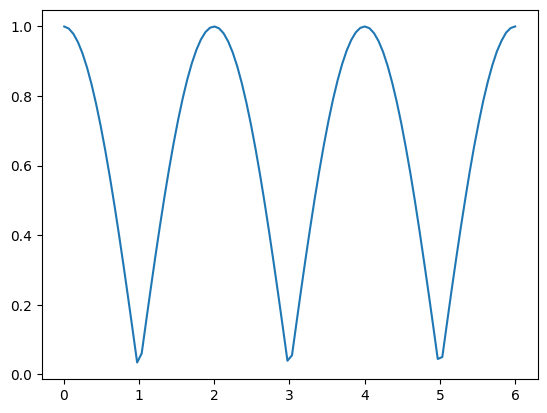

In [117]:
x=baseline.find_gates_set(plot_fidelity = True)

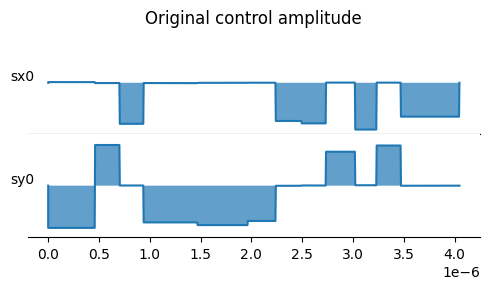

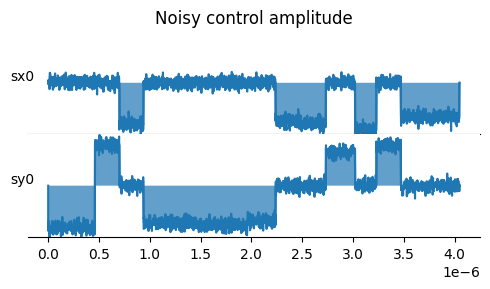

In [118]:
y = FPGA.single_sim(10,True)

In [119]:
fidelity_baseline, error_baseline = baseline.test_run(num_samples, num_gates_list)
fidelity_t1t2, error_t1t2 = t1t2.test_run(num_samples, num_gates_list)
fidelity_FPGA, error_FPGA = FPGA.test_run(num_samples, num_gates_list)
fidelity_FPGA_t1t2, error_FPGA_t1t2 = FPGA_t1t2.test_run(num_samples, num_gates_list)

Text(0, 0.5, 'Ground State Fidelity')

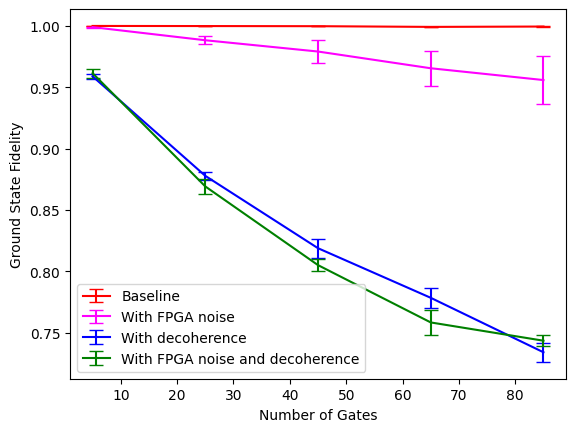

In [120]:
plt.autoscale(enable=True, axis="y", tight=False)
plt.errorbar(num_gates_list, fidelity_baseline, yerr=error_baseline, 
             color='red', capsize=5,label = 'Baseline')
plt.errorbar(num_gates_list, fidelity_FPGA, yerr=error_FPGA, 
             color='magenta', capsize=5, label = 'With FPGA noise')
plt.errorbar(num_gates_list, fidelity_t1t2, yerr=error_t1t2, 
             color='blue', capsize=5, label = 'With decoherence')
plt.errorbar(num_gates_list, fidelity_FPGA_t1t2, yerr=error_FPGA_t1t2, 
             color='green', capsize=5, label = 'With FPGA noise and decoherence')
plt.legend()
plt.xlabel("Number of Gates")
plt.ylabel("Ground State Fidelity")